In [1]:
import pandas as pd
import numpy as np
import math
import os
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt 
import seaborn as sns            # visualization tool
import matplotlib.cm as cm       #
import scipy.signal

In [2]:
def process_one_csv(foldername,k,filename):
    # print(foldername,filename)
    if(k!=0):
        path = '/home/amaya/emp/Realtime-Sign-Language-Translation-to-Speech-DNN/NEW_PROCESS/FULL_CLEANED2/'+foldername+'/split/'+k+'/'+filename
    else:
        path = '/home/amaya/emp/Realtime-Sign-Language-Translation-to-Speech-DNN/NEW_PROCESS/IH_BOTH_NEW/'+foldername+'/'+filename

    f = open(path,'rb')
    if b',' in f.readline():
        data = pd.read_csv(path)
    else:
        data = pd.read_csv(path,encoding = 'utf-16',delimiter = '\t')
    if(k!=0): 
        data = data.drop('Timestamp',axis = 1)
    else:
        data = data.drop('timestamp',axis = 1)        
    # print(data.head(2))
    if 'gyro' in filename:
        columns = list(data.columns)
    elif 'emg' in filename:
        if(k!=0):
            columns = ['Emg1', 'Emg2', 'Emg4', 'Emg6', 'Emg7']
        else:
            columns = ['emg1', 'emg2', 'emg4', 'emg6', 'emg7']            

    #features = ['E','MAX','SSC','Sk','Ku','AR']

    vector = []
    #out_columns = []
    
    for item in columns:
        temp = list(data[item])
        l = len(temp)
        
        # calculating mean
        mu = np.mean(np.array(temp))
        
        # calculating std
        dif = temp - mu
        s = np.sqrt(np.mean(np.array(dif)**2))
        
        # calculating E ***
        #out_columns.append(item+features[0])
        vector.append(np.mean(np.array(temp)**2))
        
        # calculating SSC ***
        #out_columns.append(item+features[2])
        tot = 0
        for i in range(1,l-1): 
            if (temp[i]-temp[i-1])*(temp[i+1]-temp[i]) < 0:
                tot += 1
        vector.append(tot/l-2)
        
        if 'gyro' in filename:
            # calculating max ***
            #out_columns.append(item+features[1])
            vector.append(max(temp))


        if 'emg' in filename:
            # calculating Sk ***
            # out_columns.append(item+features[3])
            vector.append((np.sum(np.array(dif)**3) * l)/((l-1)*(l-2)*(s**3)))

            # calculate Ku ***
            #out_columns.append(item+features[4])
            Ku = (np.sum(np.array(dif)**4) * l * (l+1))/((l-1)*(l-2)*(l-3)*(s**4)) - (3*((l-1)**2))/((l-2)*(l-3))
            vector.append(Ku)

            # calculating AR ***
            #out_columns.append(item+features[5])
            # suitable order = 10
            #AR, variance, coeff_reflection = aryule(temp, 4)
            #vector.extend(list(AR))

    return vector

In [3]:
count = 0
output = []
classes=[]
folders = os.listdir('/home/amaya/emp/Realtime-Sign-Language-Translation-to-Speech-DNN/NEW_PROCESS/FULL_CLEANED2/')
# print(len(out_columns))

# process_one_csv(files[0])
for folder in folders:
    if folder[0] != '.':
        class_ = folder[:-11]
        
        for k in ['1', '2']:
            files = sorted(os.listdir('/home/amaya/emp/Realtime-Sign-Language-Translation-to-Speech-DNN/NEW_PROCESS/FULL_CLEANED2/'+folder+'/split/'+k+'/'))
            
            temp = []
            for file in files:
                if file[-1] == 'v' and (('gyro' in file) or ('emg' in file)):
                    temp += process_one_csv(folder,k,file)
            if class_ in classes:
                temp.append(classes.index(class_))
            else:
                classes.append(class_)
                temp.append(classes.index(class_))
            #if count == 29:
                #print(folder,k,file)
            #count += 1
            output.append(temp)
            

In [4]:
count = 0
folders = os.listdir('/home/amaya/emp/Realtime-Sign-Language-Translation-to-Speech-DNN/NEW_PROCESS/IH_BOTH_NEW/')
# print(len(out_columns))

# process_one_csv(files[0])
for folder in folders:
    if folder[0] != '.':
        class_ = folder[:-17]
        
        files = sorted(os.listdir('/home/amaya/emp/Realtime-Sign-Language-Translation-to-Speech-DNN/NEW_PROCESS/IH_BOTH_NEW/'+folder+'/'))
            
        temp = []
        for file in files:
            if file[-1] == 'v' and (('gyro' in file) or ('emg' in file)):
                temp += process_one_csv(folder,0,file)
        if class_ in classes:
            temp.append(classes.index(class_))
        else:
            classes.append(class_)
            temp.append(classes.index(class_))
        #if count == 29:
            #print(folder,k,file)
        #count += 1
        output.append(temp)
            
processed = pd.DataFrame(output)
ocolumns = list(processed.columns)
#processed = initial_df[ocolumns]
processed.head()
print(classes)

['YELLOW', 'WATER', 'YES', 'THANKYOU', 'NO']


In [5]:
processed.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,416.366338,-1.974490,0.694468,-0.639694,108.755353,-1.968367,0.683196,-0.416161,43.514615,-1.972449,...,1102.491401,-1.931937,42.871890,2313.491837,-1.984293,74.722949,1317.906575,-1.984293,54.524040,0
1,202.984862,-1.952612,0.817356,0.112530,100.843110,-1.964763,0.065711,-0.908039,47.426701,-1.967193,...,885.682984,-1.924623,36.748547,1983.106925,-1.984925,70.611385,1148.560591,-1.984925,50.985131,0
2,135.666078,-1.962042,0.644536,0.037629,80.420641,-1.975131,0.913353,0.182295,30.849639,-1.972513,...,968.808077,-1.951327,42.873981,2317.918867,-1.986726,80.597075,952.529188,-1.986726,50.249259,0
3,224.304604,-1.964109,1.623689,2.874839,84.771866,-1.964109,0.272399,-0.672410,40.526828,-1.983911,...,816.347656,-1.947867,37.948618,2471.691043,-1.985782,80.317119,926.636653,-1.966825,49.259067,0
4,441.559727,-1.956897,0.747946,-0.641441,164.748514,-1.949507,0.886376,-0.065303,25.916920,-1.939655,...,403.636721,-1.936585,25.305731,5655.153686,-1.985366,115.683595,590.178219,-1.956098,39.452069,1


In [6]:
len(ocolumns)

30

In [7]:
processed.shape

(508, 30)

In [8]:
X = processed[ocolumns[:-1]]
y = processed[ocolumns[-1]]

In [9]:
scaler = preprocessing.MinMaxScaler()   # since the data set is not gaussian
scaled_df = scaler.fit_transform(X)
X = pd.DataFrame(scaled_df,columns = ocolumns[:-1])
y = processed[ocolumns[-1]]

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.20)

In [11]:
'''%store X_train
%store y_train
%store X_test
%store y_test'''

Stored 'X_train' (DataFrame)
Stored 'y_train' (Series)
Stored 'X_test' (DataFrame)
Stored 'y_test' (Series)


In [12]:
'''X_pro =  processed[ocolumns[:-1]]
y_pro =  processed[ocolumns[-1]]
%store X_pro
%store y_pro
X_pro.head()'''

Stored 'X_pro' (DataFrame)
Stored 'y_pro' (Series)


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,416.366338,-1.974490,0.694468,-0.639694,108.755353,-1.968367,0.683196,-0.416161,43.514615,-1.972449,...,-1.166054,1102.491401,-1.931937,42.871890,2313.491837,-1.984293,74.722949,1317.906575,-1.984293,54.524040
1,202.984862,-1.952612,0.817356,0.112530,100.843110,-1.964763,0.065711,-0.908039,47.426701,-1.967193,...,0.587504,885.682984,-1.924623,36.748547,1983.106925,-1.984925,70.611385,1148.560591,-1.984925,50.985131
2,135.666078,-1.962042,0.644536,0.037629,80.420641,-1.975131,0.913353,0.182295,30.849639,-1.972513,...,0.338247,968.808077,-1.951327,42.873981,2317.918867,-1.986726,80.597075,952.529188,-1.986726,50.249259
3,224.304604,-1.964109,1.623689,2.874839,84.771866,-1.964109,0.272399,-0.672410,40.526828,-1.983911,...,-0.304151,816.347656,-1.947867,37.948618,2471.691043,-1.985782,80.317119,926.636653,-1.966825,49.259067
4,441.559727,-1.956897,0.747946,-0.641441,164.748514,-1.949507,0.886376,-0.065303,25.916920,-1.939655,...,-0.037226,403.636721,-1.936585,25.305731,5655.153686,-1.985366,115.683595,590.178219,-1.956098,39.452069


In [13]:
'''%store -r X_pro
%store -r y_pro
X_min = X_pro.min(axis=0)
X_max = X_pro.max(axis=0)
np.savetxt('DNNX_min_new.txt', pd.DataFrame(X_min).transpose().iloc[0].values, fmt='%f')
np.savetxt('DNNX_max_new.txt', pd.DataFrame(X_max).transpose().iloc[0].values, fmt='%f')'''

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
cb = [EarlyStopping(monitor = 'val_acc', mode = 'max', verbose = 1, patience = 20, min_delta = 1,restore_best_weights = True)]

In [14]:
# setting up the layers
from tensorflow.keras.regularizers import l2

model = keras.Sequential([
    #,activity_regularizer=l2(0.2)
    keras.layers.Dense(17,input_dim = 29,activation = 'relu'),
    keras.layers.Dense(20,activation = 'relu'),
    keras.layers.Dense(5,activation = 'softmax')
])
model.summary()
# compile the model
#from tensorflow.keras.optimizers import Adam
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

W1109 14:56:29.847357 140118574925568 deprecation.py:506] From /home/amaya/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 17)                510       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                360       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
Total params: 975
Trainable params: 975
Non-trainable params: 0
_________________________________________________________________


In [15]:
%store -r X_train
%store -r y_train
%store -r X_test
%store -r y_test

In [17]:
trained_model = model.fit(X_train,y_train,epochs = 45,batch_size = 10,validation_split = 0.2,verbose=2)


Train on 324 samples, validate on 82 samples
Epoch 1/45
324/324 - 1s - loss: 1.5693 - acc: 0.3210 - val_loss: 1.5452 - val_acc: 0.4512
Epoch 2/45
324/324 - 0s - loss: 1.4885 - acc: 0.5093 - val_loss: 1.4765 - val_acc: 0.5366
Epoch 3/45
324/324 - 0s - loss: 1.3988 - acc: 0.5895 - val_loss: 1.3881 - val_acc: 0.5488
Epoch 4/45
324/324 - 0s - loss: 1.2878 - acc: 0.6667 - val_loss: 1.2901 - val_acc: 0.6220
Epoch 5/45
324/324 - 0s - loss: 1.1735 - acc: 0.6944 - val_loss: 1.1935 - val_acc: 0.6463
Epoch 6/45
324/324 - 0s - loss: 1.0646 - acc: 0.7685 - val_loss: 1.0966 - val_acc: 0.6951
Epoch 7/45
324/324 - 0s - loss: 0.9639 - acc: 0.7963 - val_loss: 1.0055 - val_acc: 0.7683
Epoch 8/45
324/324 - 0s - loss: 0.8741 - acc: 0.8117 - val_loss: 0.9188 - val_acc: 0.7805
Epoch 9/45
324/324 - 0s - loss: 0.7937 - acc: 0.8580 - val_loss: 0.8300 - val_acc: 0.7805
Epoch 10/45
324/324 - 0s - loss: 0.7170 - acc: 0.8704 - val_loss: 0.7740 - val_acc: 0.8049
Epoch 11/45
324/324 - 0s - loss: 0.6530 - acc: 0.8735 

In [20]:
#model.save('all_new_model.h5')

In [19]:
test_loss,test_acc = model.evaluate(X_test,y_test)
print(test_acc)

102/102 [==============================] - 0s 247us/sample - loss: 0.0991 - acc: 0.9902
0.99019605


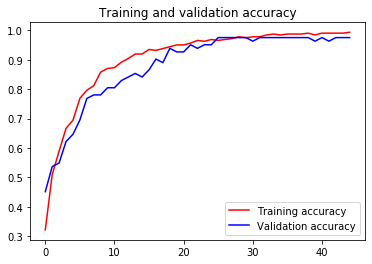

<Figure size 432x288 with 0 Axes>

In [21]:
acc = trained_model.history['acc']
val_acc = trained_model.history['val_acc']
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()